# TO-DO

- Dataloader
- Metric (Dice-Loss)

In [8]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 155 
VOLUME_START_AT = 0 # first slice of volume that we will include
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [9]:
TRAIN_DATASET_PATH = './BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = './BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

In [10]:
arr = np.array(test_mask)
ten = torch.from_numpy(arr)
ten[ten==4] = 3
print(torch.unique(ten))
print(ten.shape)

tensor([0., 1., 2., 3.], dtype=torch.float64)
torch.Size([240, 240, 155])


Text(0.5, 1.0, 'Mask')

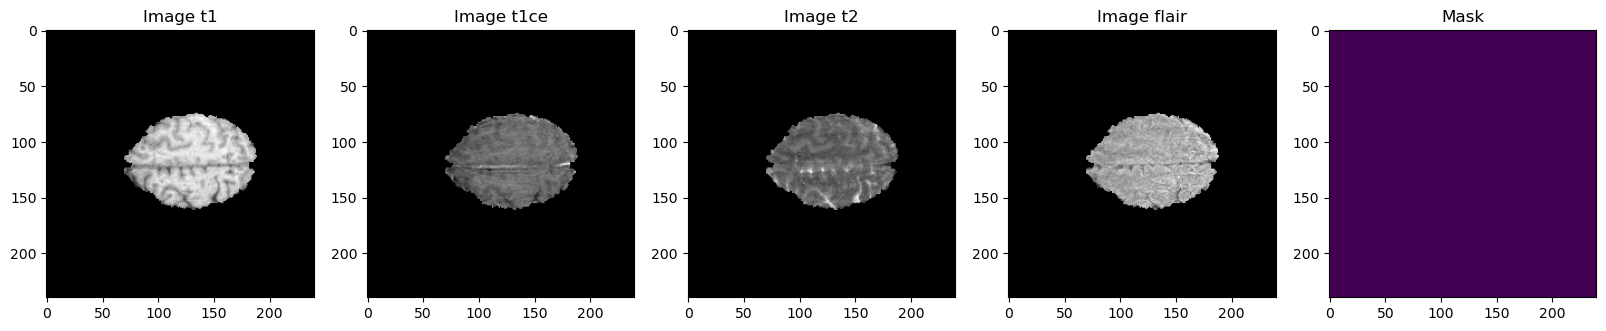

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 0
ax1.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image t1')
ax2.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1ce')
ax3.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t2')
ax4.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image flair')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

Text(0.5, 1.0, 'Mask')

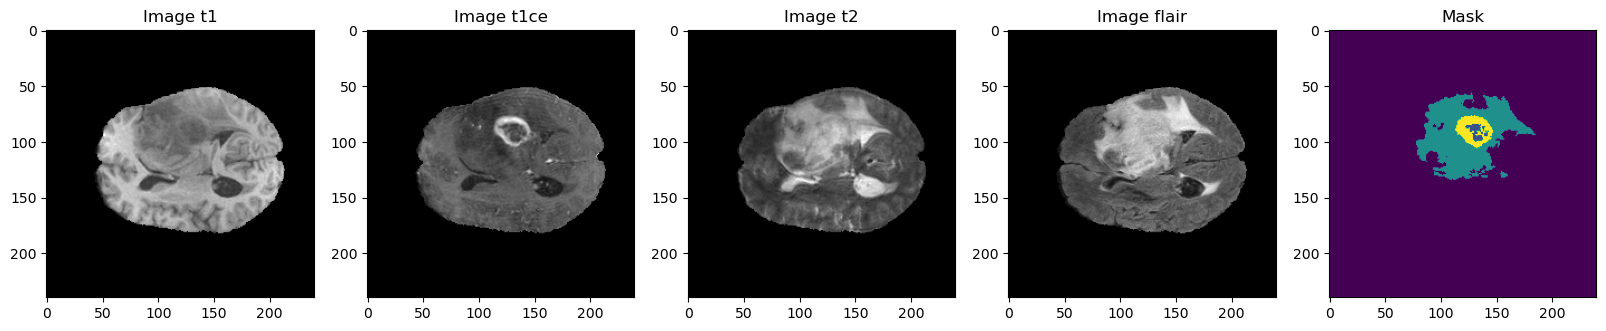

In [12]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 75
ax1.imshow(test_image_t1[:, :, slice_w], cmap='gray')
ax1.set_title('Image t1')
ax2.imshow(
    test_image_t1ce[:, :, slice_w], cmap='gray')
ax2.set_title('Image t1ce')
ax3.imshow(test_image_t2[:, :, slice_w], cmap='gray')
ax3.set_title('Image t2')
ax4.imshow(
    test_image_flair[:, :, slice_w], cmap='gray')
ax4.set_title('Image flair')
ax5.imshow(test_mask[:, :, slice_w])
ax5.set_title('Mask')


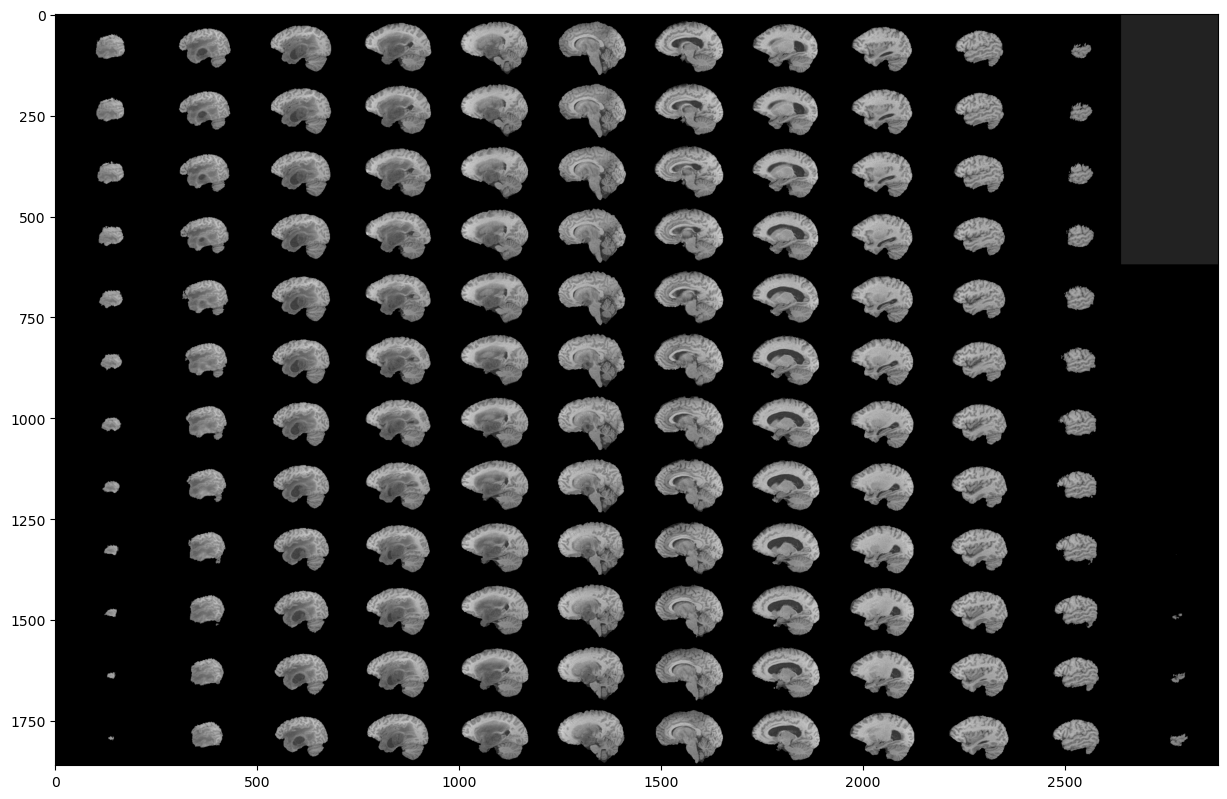

In [13]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

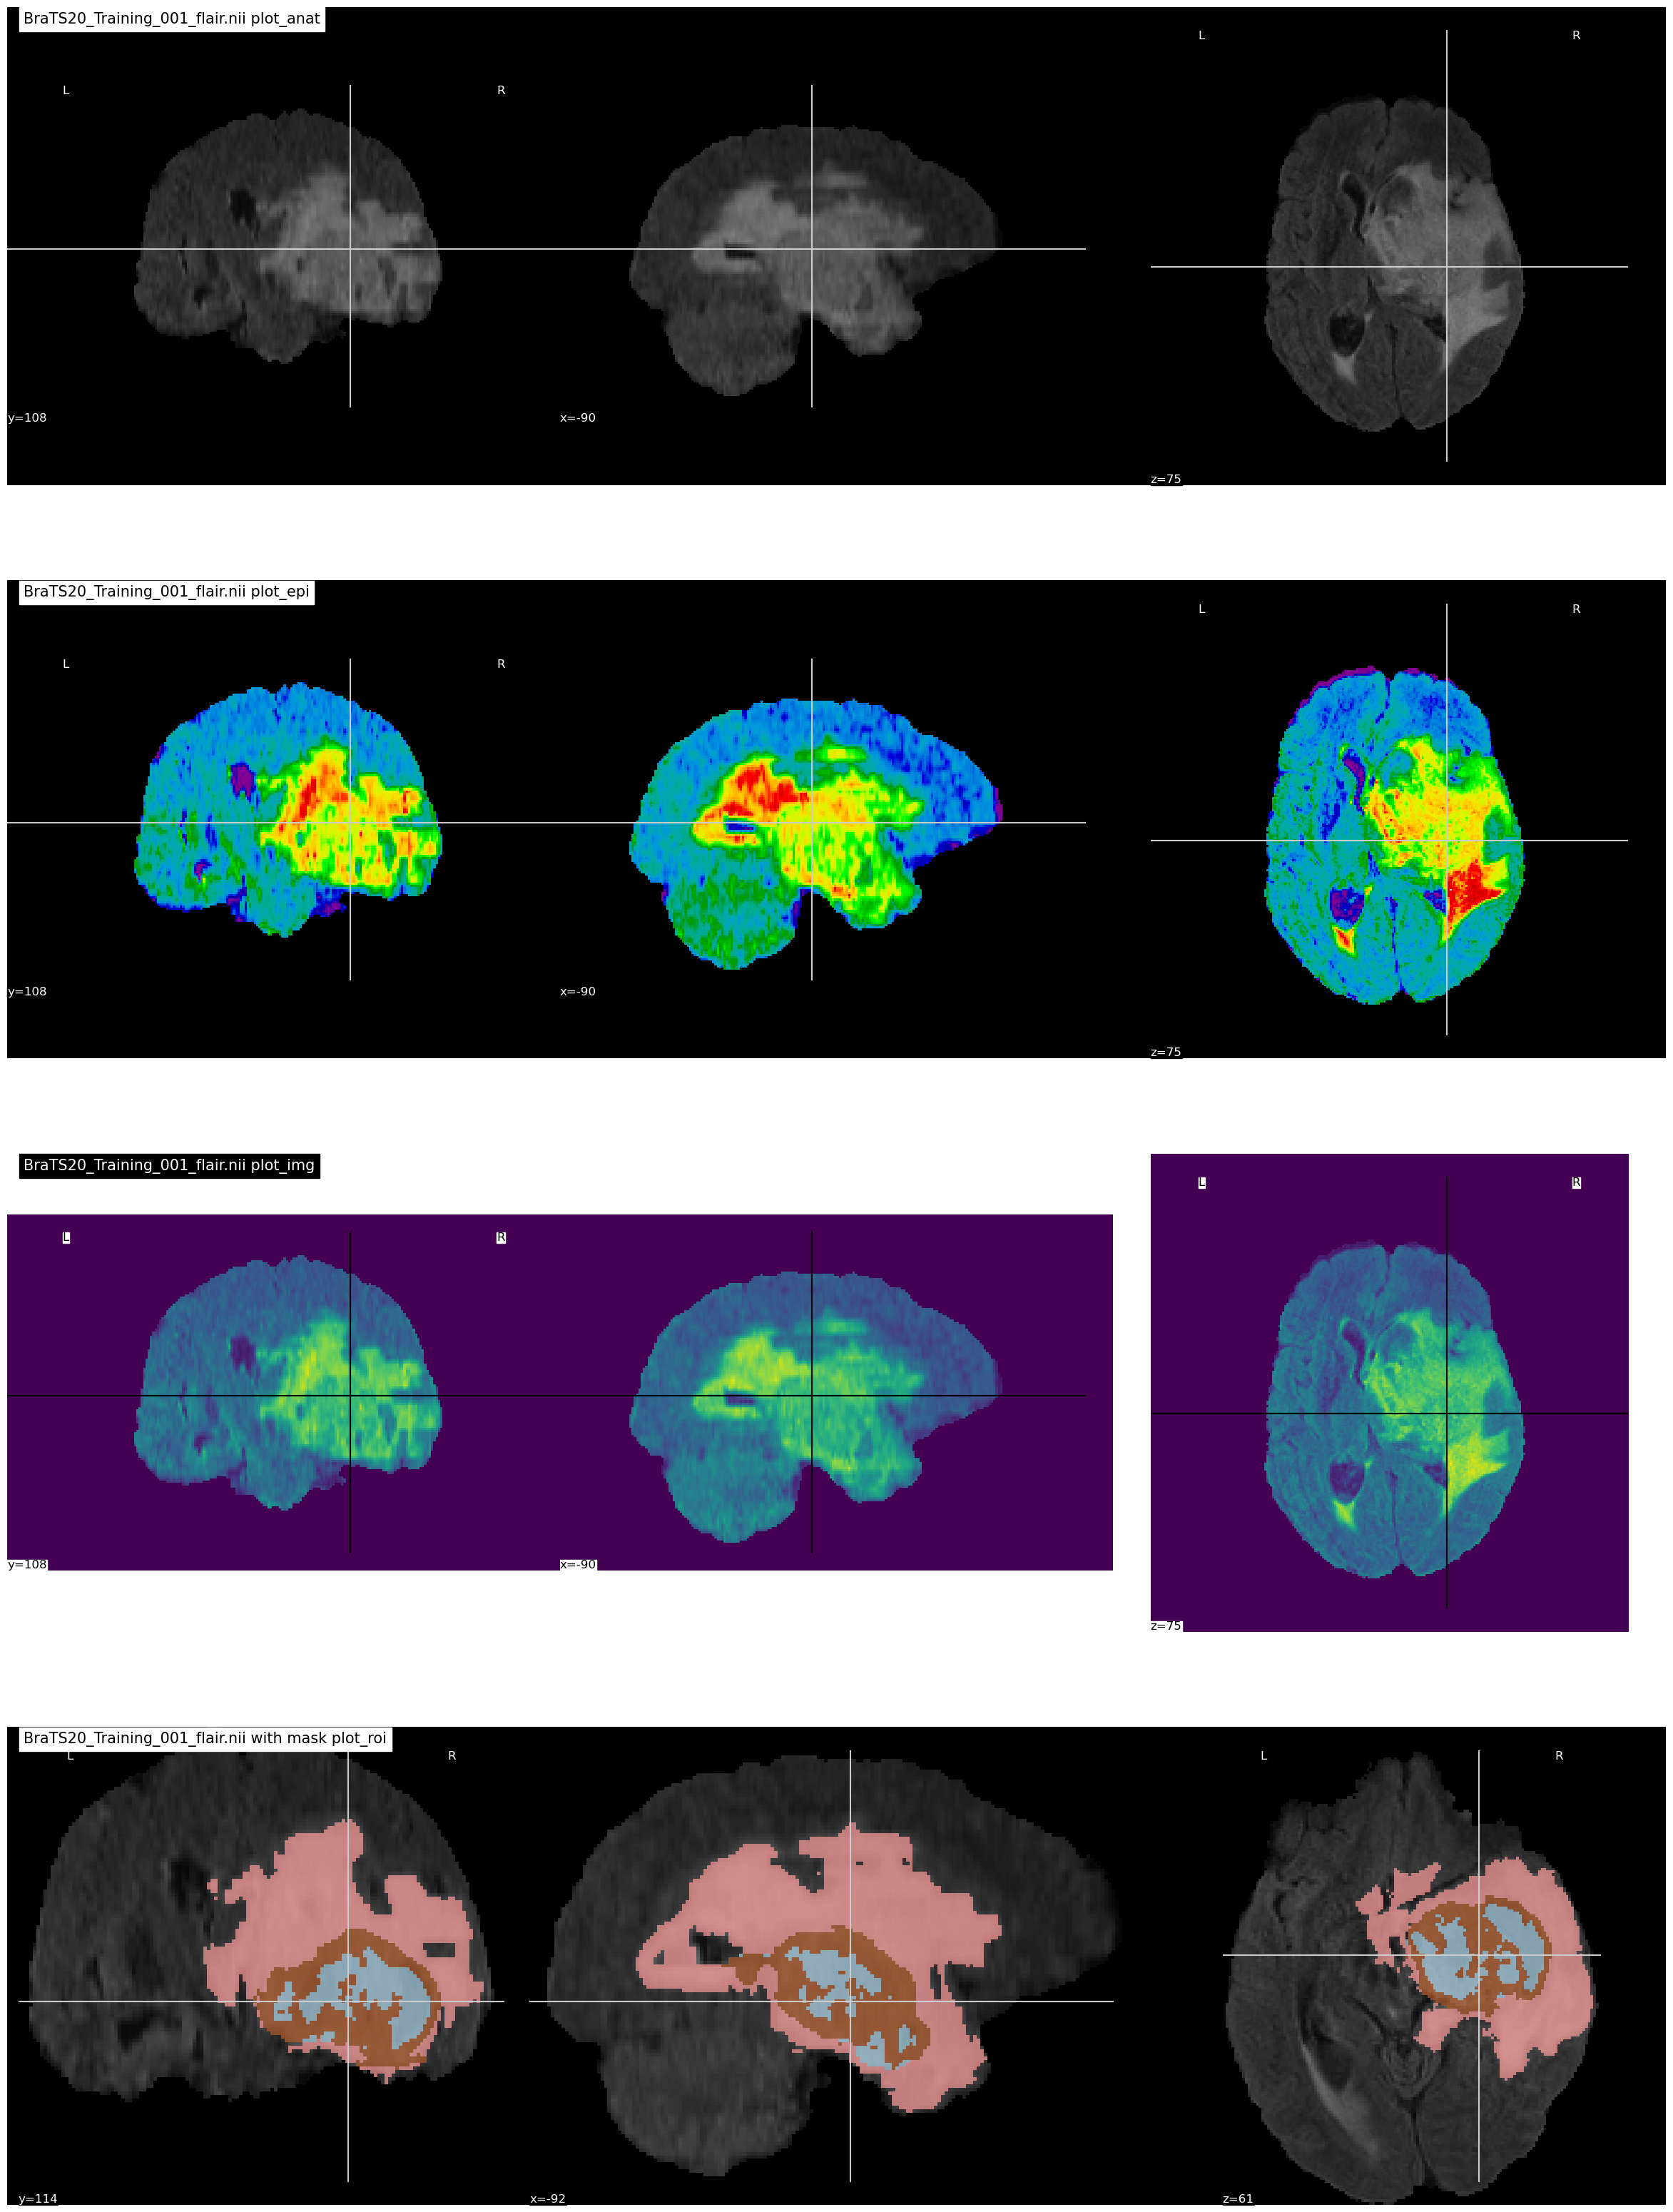

In [14]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [15]:
def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
def normalize(self, data: np.ndarray):
    data_min = np.min(data)
    return (data - data_min) / (np.max(data) - data_min)

In [16]:
# import torch
# from torch.utils.data import Dataset
# from torchvision.transforms import ToTensor
# import torch.nn.functional as F
# import torchvision.transforms as T

# IMG_SIZE = test_image_flair.shape[0] # should be 240 by default
# VOLUME_SLICES = test_image_flair.shape[2] # should be 155 by default

# class BraTSDataset(Dataset):
#     def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 4, shuffle=True):
#         self.dim = dim
#         self.batch_size = batch_size
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
#         # Find list of IDs
#         batch_ids = [self.list_IDs[k] for k in indexes]
        
#         # Initialization
#         X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
#         y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
#         # Y = torch.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))
#         transform = T.Resize((IMG_SIZE, IMG_SIZE))
#         # './BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/4/4_t1.nii'
#         # actual: BraTS20_Training_001/BraTS20_Training_001_flair.nii
#         for c, i in enumerate(batch_ids):
#             print(c,i)
#             case_path = os.path.join(TRAIN_DATASET_PATH, f"BraTS20_Training_{i:03d}")

#             data_path = os.path.join(case_path, f'BraTS20_Training_{i:03d}_t1.nii')
#             t1 = nib.load(data_path).get_fdata()    
            
#             data_path = os.path.join(case_path, f'BraTS20_Training_{i:03d}_t1ce.nii')
#             t1ce = nib.load(data_path).get_fdata()   

#             data_path = os.path.join(case_path, f'BraTS20_Training_{i:03d}_t2.nii')
#             t2 = nib.load(data_path).get_fdata()
            
#             data_path = os.path.join(case_path, f'BraTS20_Training_{i:03d}_flair.nii')
#             flair = nib.load(data_path).get_fdata()   
            
#             data_path = os.path.join(case_path, f'BraTS20_Training_{i:03d}_seg.nii')
#             seg = nib.load(data_path).get_fdata()
        
#             for j in range(VOLUME_SLICES):
#                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(t1[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
#                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
#                 X[j +VOLUME_SLICES*c,:,:,2] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
#                 X[j +VOLUME_SLICES*c,:,:,3] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

#                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
                
#         # Generate masks because for some reason, original dataset's labels are 0, 1, 2 and 4.
#         y[y==4] = 3
#         # print(y)
#         y = torch.from_numpy(y[0])
#         mask = F.one_hot(y.long(), 4)
#         transform = T.Resize((IMG_SIZE, IMG_SIZE))
#         label = transform(mask)
        
#         data = torch.from_numpy(X/np.max(X))
        
#         # returns normalised data tensor and segmentation labels
#         return data, label
    
        
#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torchvision.transforms as T

IMG_SIZE = test_image_flair.shape[0]  # should be 240 by default
VOLUME_SLICES = test_image_flair.shape[2]  # should be 155 by default


class BraTSDataset2020(Dataset):
    def __init__(self, training=True):
        self.training = training
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.trainValStr = "Training" if training else "Validation"
        self.path = TRAIN_DATASET_PATH if training else VALIDATION_DATASET_PATH
        # self.on_epoch_end()

    def __len__(self):
        return sum(f"BraTS20_{self.trainValStr}" in x for x in os.listdir(self.path))

    def __getitem__(self, index):
        # Generate indexes of the batch
        index = index+1
        imgPath = os.path.join(self.path, f"BraTS20_{self.trainValStr}_{index:03d}")
        t1 = self.load_img(os.path.join(imgPath, f'BraTS20_{self.trainValStr}_{index:03d}_t1.nii'))
        t1 = torch.from_numpy(t1)
        t1ce = self.load_img(os.path.join(imgPath, f'BraTS20_{self.trainValStr}_{index:03d}_t1ce.nii'))
        t1ce = torch.from_numpy(t1ce)
        t2 = self.load_img(os.path.join(imgPath, f'BraTS20_{self.trainValStr}_{index:03d}_t2.nii'))
        t2 = torch.from_numpy(t2)
        flair = self.load_img(os.path.join(imgPath, f'BraTS20_{self.trainValStr}_{index:03d}_flair.nii'))
        flair = torch.from_numpy(flair)
        
        data = torch.stack((t1, t1ce, t2, flair),dim=3)
        data = torch.reshape(data, (4, 155, 240, 240))
        if self.training:
            
            seg = self.load_img(os.path.join(imgPath, f'BraTS20_{self.trainValStr}_{index:03d}_seg.nii'))
                
            # Generate masks because original dataset's labels are 0, 1, 2 and 4.
            seg = seg.astype("int8")
            seg[seg == 4] = 3
            seg = torch.from_numpy(seg)
            seg = torch.stack([(seg == i).int() for i in range(0, 4)], dim=3)
            seg = torch.reshape(seg, (4, 155, 240, 240))
            return data, seg
        
        else:
            return data

    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    # def on_epoch_end(self):
    #     'Updates indexes after each epoch'
    #     self.indexes = np.arange(len(self.list_IDs))
    #     if self.shuffle == True:
    #         np.random.shuffle(self.indexes)




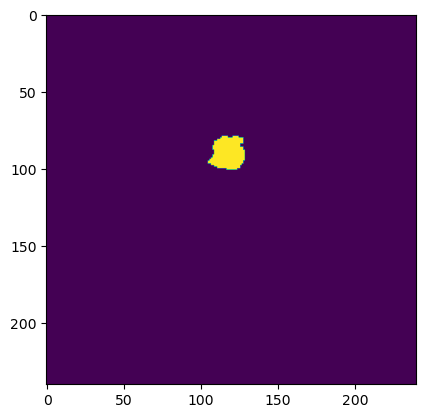

In [33]:
idx = 355
slice_n = 75
weirdpath = os.path.join(TRAIN_DATASET_PATH,
      f"BraTS20_Training_{idx}/BraTS20_Training_{idx}_seg.nii")


def load_img(file_path):
    data = nib.load(file_path)
    data = np.asarray(data.dataobj)
    return data

myseg = load_img(weirdpath)

    
fig, ax = plt.subplots(1,1)
ax.imshow(myseg[:,:,slice_n])

torch.Size([4, 155, 240, 240])
torch.Size([240, 240, 155, 4])
torch.Size([4, 155, 240, 240])


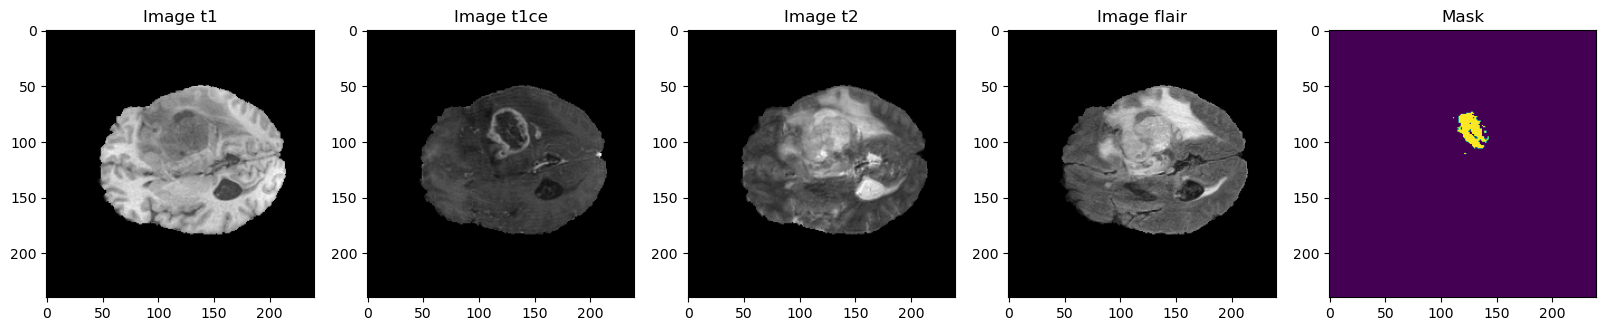

In [34]:
train_dataset = BraTSDataset2020()
sample1 = train_dataset[0]
data1 = sample1[0].reshape((240,240,155,4))
# label1 = data1[1]
print(sample1[1].shape)
label1 = sample1[1].reshape((240, 240, 155, 4))
print(label1.shape)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 69
ax1.imshow(data1[:, :, slice_w, 0], cmap='gray')
ax1.set_title('Image t1')
ax2.imshow(data1[:, :, slice_w, 1], cmap='gray')
ax2.set_title('Image t1ce')
ax3.imshow(data1[:, :, slice_w, 2], cmap='gray')
ax3.set_title('Image t2')
ax4.imshow(data1[:, :, slice_w, 3], cmap='gray')
ax4.set_title('Image flair')
ax5.imshow(label1[:, :, slice_w, 1])
ax5.set_title('Mask')
print(train_dataset[0][0].shape)


In [20]:
# label1.shape
# label1More = torch.cat((label1,torch.zeros((240,240,155,1))),dim=3)
# label1More.shape
# label1More[:,:,:,3].unique()

In [35]:
label1Max = torch.argmax(label1, dim=3)
print(label1Max.shape)
print(label1Max.unique())


torch.Size([240, 240, 155])
tensor([0, 1, 2, 3])


Text(0.5, 1.0, 'Mask')

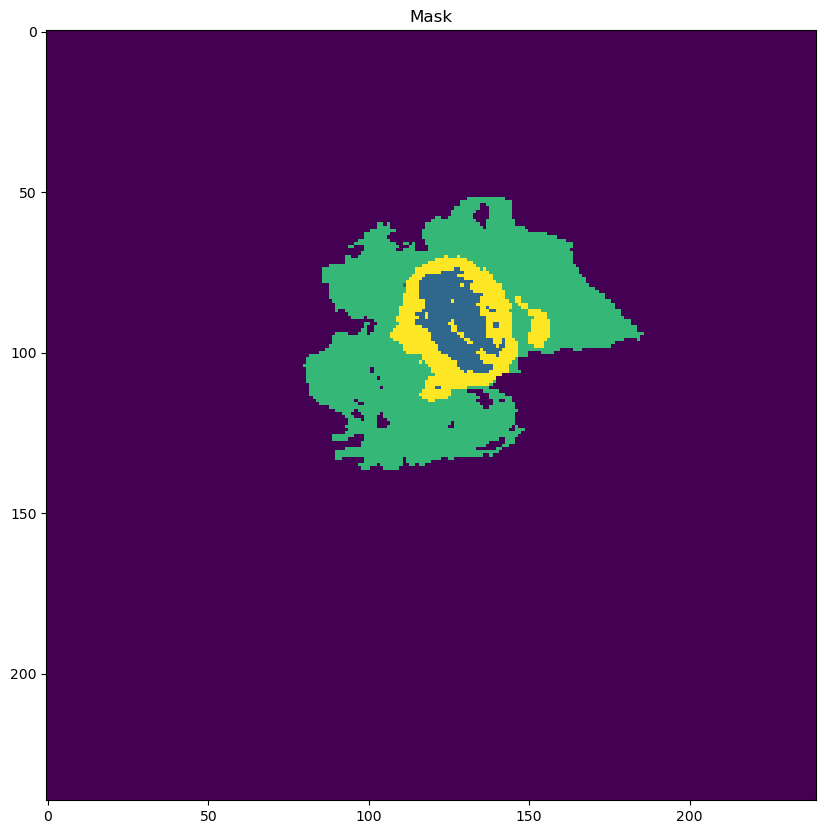

In [22]:

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))
slice_w = 69
ax1.imshow(label1Max[:, :, slice_w])
ax1.set_title('Mask')


In [36]:
valid_dataset = BraTSDataset2020(training=False)
print(len(valid_dataset))
print(len(train_dataset))


125
369


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""

    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels,
                      kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels,
                      kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.encoder(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(
                scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(
                in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY //
                   2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet3D(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask


In [38]:
import torch.optim as optim

# len(dataloader)
# data = next(iter(dataloader))
# print(data)

num_epochs = 2
learning_rate = 0.001

class DiceLoss(nn.Module):
    """Calculate dice loss."""

    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert (probability.shape == targets.shape)

        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score

model = UNet3D(in_channels=4, n_classes=4, n_channels=16).to('cuda')
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [39]:
# dataloaders
BATCH_SIZE = 2
NUM_WORKERS = 1
SHUFFLE = True


def get_train_loader(batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS):
    # train_transforms = get_brats2021_train_transform(args)
    train_dataset = BraTSDataset2020()
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle,
                      drop_last=False, num_workers=num_workers, pin_memory=True)


def get_valid_loader():
    # train_transforms = get_brats2021_train_transform(args)
    valid_dataset = BraTSDataset2020(training=False)
    return DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE,
                      drop_last=False, num_workers=NUM_WORKERS, pin_memory=True)

trainloader = get_train_loader()
testloader = get_valid_loader()
for epoch in range(num_epochs):

    # dt_loader_train = DataLoader(dtset, batch_size=batch_size, shuffle=True)
    for batch_index, batch in enumerate(trainloader):

        image = batch[0]
        mask = batch[1]
        # print(image.shape)

        image = image.to(device=device, dtype=torch.float)
        mask = mask.to(device=device, dtype=torch.float)
        
        y_pred = model(image)
        # print(image.shape)
        # print(mask.shape)
        # print(y_pred.shape)
        loss = criterion(y_pred.float(), mask)
        print('Epoch ', epoch, '  iter ', batch_index, '  loss : ', loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #     break
    # break

    # torch.save(model.state_dict(), ckpt_path)

    

Epoch  0   iter  0   loss :  0.6823295950889587
Epoch  0   iter  1   loss :  0.6664431095123291
Epoch  0   iter  2   loss :  0.6530231237411499
Epoch  0   iter  3   loss :  0.6427584886550903
Epoch  0   iter  4   loss :  0.6368979215621948
Epoch  0   iter  5   loss :  0.6430091857910156
Epoch  0   iter  6   loss :  0.6162180304527283
Epoch  0   iter  7   loss :  0.6015678644180298
Epoch  0   iter  8   loss :  0.5897307395935059
Epoch  0   iter  9   loss :  0.5792254209518433
Epoch  0   iter  10   loss :  0.5605084896087646
Epoch  0   iter  11   loss :  0.5907564163208008
Epoch  0   iter  12   loss :  0.5509664416313171
Epoch  0   iter  13   loss :  0.5509830713272095
Epoch  0   iter  14   loss :  0.5232542753219604
Epoch  0   iter  15   loss :  0.5796920657157898
Epoch  0   iter  16   loss :  0.6112135648727417
Epoch  0   iter  17   loss :  0.6172688007354736
Epoch  0   iter  18   loss :  0.6190885305404663
Epoch  0   iter  19   loss :  0.5007752180099487
Epoch  0   iter  20   loss :  

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/incomple_/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/incomple_/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 61, in fetch
    return self.collate_fn(data)
  File "/home/incomple_/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/incomple_/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 143, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/incomple_/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 143, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/home/incomple_/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 120, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/home/incomple_/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 163, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: torch.cat(): input types can't be cast to the desired output type Short


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss
import time


def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert (predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""

    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert (logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)

        return bce_loss + dice_loss


class Meter:
    '''factory for storing and updating iou and dice scores.'''

    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)

    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """

    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                 ):
        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val": val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        # self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = self.criterion(logits, targets)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, (images, targets) in enumerate(dataloader):
            #             print(images.shape, targets.shape)
            #             images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                         )

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        # self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss

    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    def _plot_train_history(self):
        data = [self.losses, self.dice_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,

            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """,

            # f"""
            # train jaccard score {self.jaccard_scores['train'][-1]}
            # val jaccard score {self.jaccard_scores['val'][-1]}
            # """,
        ]

        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")

    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores]
        log_names_ = ["_loss", "_dice"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                     ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)


In [ ]:
assert (1 == 0)

In [28]:
# del model
# torch.cuda.empty_cache()


NameError: name 'model' is not defined

In [29]:
# myBatch



In [ ]:
print(myMask.unique())
print(myPred.unique())

# probability = torch.sigmoid(myPred)
# print(probability.unique())
# print(probability.shape)
# prob2 = torch.where(probability < 0.5, 0, 1)
# print(prob2.unique())
# print(prob2.shape)
predicted_labels = torch.argmax(myPred, dim=-1)

# myPredCombined = torch.argmax(probability, dim=3)
# print(myPredCombined.shape)
# print(myPredCombined.unique())


In [ ]:
myPredCombined = torch.argmax(myPred, dim=-1)
myPredCombined.unique()

In [ ]:
myBatch = next(iter(trainloader))
image = myBatch[0]
mask = myBatch[1]
image = image.to(device=device, dtype=torch.float)
mask = mask.to(device=device, dtype=torch.float)
with torch.no_grad():
  y_pred = model(image)
print(image[0].shape)
print(mask[0].shape)
print(y_pred[0].shape)
myImage = image[0].reshape((240, 240, 155, 4))
myMask = mask[0].reshape((240, 240, 155, 4))
myPred = y_pred[0].reshape((240, 240, 155, 4))
myMaskCombined = torch.argmax(myMask, dim=-1)
myPredCombined = torch.argmax(myPred, dim=-1)
print(myMaskCombined.shape)
print(myMaskCombined.unique())
print(myPredCombined.shape)
print(myPredCombined.unique())

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20, 10))
slice_w = 101
ax1.imshow(myImage[:, :, slice_w, 0].cpu(), cmap='gray')
ax1.set_title('Image t1')
ax2.imshow(myImage[:, :, slice_w, 1].cpu(), cmap='gray')
ax2.set_title('Image t1ce')
ax3.imshow(myImage[:, :, slice_w, 2].cpu(), cmap='gray')
ax3.set_title('Image t2')
ax4.imshow(myImage[:, :, slice_w, 3].cpu(), cmap='gray')
ax4.set_title('Image flair')
ax5.imshow(myMaskCombined[:, :, slice_w].cpu())
ax5.set_title('Mask')
ax6.imshow(myPredCombined[:, :, slice_w].cpu())
ax6.set_title('Pred')
print(myPredCombined[:, :, slice_w].unique())


In [ ]:
torch.cuda.empty_cache()
torch.cuda.synchronize()


In [ ]:
with torch.no_grad():
    img_t1ce_test = img_t1ce_test.to(device)

    # Generate prediction
    prediction = model(img_t1ce_test)

    prediction = np.squeeze(prediction, axis=0)

    prediction = prediction.cpu().numpy()

    predicted_class = np.argmax(prediction, axis=0)

    predicted_class = np.array(predicted_class, dtype=np.uint8)

    predicted_class[predicted_class == 3] = 4

    # Show result
    plt.imshow(predicted_class, cmap='gray')
    plt.show()

    # Show mask
    plt.imshow(mask_t1ce_test, cmap='gray')
    plt.show()


In [ ]:
print(sum("BraTS20_Training" in x for x in os.listdir(TRAIN_DATASET_PATH)))
# print(sum(os.path.isdir(i) for i in os.listdir(TRAIN_DATASET_PATH)))


In [ ]:
print(len(os.path.isdir(i) for i in os.listdir(TRAIN_DATASET_PATH)))


In [ ]:
print(np.arange(5))

In [ ]:
datagen = BraTSDataset2020([1, 2, 3, 4, 5])
# print(len(datagen))
# # print(datagen[0])
# for i in datagen:
#   print("hi")

In [ ]:
print(sample1[2])


In [ ]:
sample1 = datagen[0]
data1 = sample1[0]
label1 = sample1[1]
print(data1[55,:,:,1].shape)

In [ ]:
print(label1.shape)

In [ ]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import nibabel as nib
import torchio as tio


class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(
            in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class SelfAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout):
        super().__init__()
        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(embed_dim, self.all_head_size)
        self.key = nn.Linear(embed_dim, self.all_head_size)
        self.value = nn.Linear(embed_dim, self.all_head_size)

        self.out = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        self.softmax = nn.Softmax(dim=-1)

        self.vis = False

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[
            :-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(
            query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / \
            math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[
            :-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


class Mlp(nn.Module):
    def __init__(self, in_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, in_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1()
        x = self.act(x)
        x = self.drop(x)
        return x


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model=786, d_ff=2048, dropout=0.1):
        super().__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class Embeddings(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super().__init__()
        self.n_patches = int(
            (cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=input_dim, out_channels=embed_dim,
                                          kernel_size=patch_size, stride=patch_size)
        self.position_embeddings = nn.Parameter(
            torch.zeros(1, self.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout, cube_size, patch_size):
        super().__init__()
        self.attention_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp_dim = int(
            (cube_size[0] * cube_size[1] * cube_size[2]) / (patch_size * patch_size * patch_size))
        self.mlp = PositionwiseFeedForward(embed_dim, 2048)
        self.attn = SelfAttention(num_heads, embed_dim, dropout)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x

        x = self.mlp_norm(x)
        x = self.mlp(x)

        x = x + h
        return x, weights


class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, num_heads, num_layers, dropout, extract_layers):
        super().__init__()
        self.embeddings = Embeddings(
            input_dim, embed_dim, cube_size, patch_size, dropout)
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.extract_layers = extract_layers
        for _ in range(num_layers):
            layer = TransformerBlock(
                embed_dim, num_heads, dropout, cube_size, patch_size)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, x):
        extract_layers = []
        hidden_states = self.embeddings(x)

        for depth, layer_block in enumerate(self.layer):
            hidden_states, _ = layer_block(hidden_states)
            if depth + 1 in self.extract_layers:
                extract_layers.append(hidden_states)

        return extract_layers


class UNETR(nn.Module):
    def __init__(self, img_shape=(128, 128, 128), input_dim=4, output_dim=3, embed_dim=768, patch_size=16, num_heads=12, dropout=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]

        # Transformer Encoder
        self.transformer = \
            Transformer(
                input_dim,
                embed_dim,
                img_shape,
                patch_size,
                num_heads,
                self.num_layers,
                dropout,
                self.ext_layers
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, 32, 3),
                Conv3DBlock(32, 64, 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
                Deconv3DBlock(256, 128)
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, 512),
                Deconv3DBlock(512, 256),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, 512)

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, 512)

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(1024, 512),
                Conv3DBlock(512, 512),
                Conv3DBlock(512, 512),
                SingleDeconv3DBlock(512, 256)
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(512, 256),
                Conv3DBlock(256, 256),
                SingleDeconv3DBlock(256, 128)
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(256, 128),
                Conv3DBlock(128, 128),
                SingleDeconv3DBlock(128, 64)
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(128, 64),
                Conv3DBlock(64, 64),
                SingleConv3DBlock(64, output_dim, 1)
            )

    def forward(self, x):
        z = self.transformer(x)
        z0, z3, z6, z9, z12 = x, *z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output


In [ ]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3D(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask